In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
data_dir = r"E:\Computer Vision\Cellula Tech\Task 1\Teeth_Dataset"
img_size = (224, 224)
batch_size = 32


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    color_mode="rgb"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "validation"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    color_mode="rgb"
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

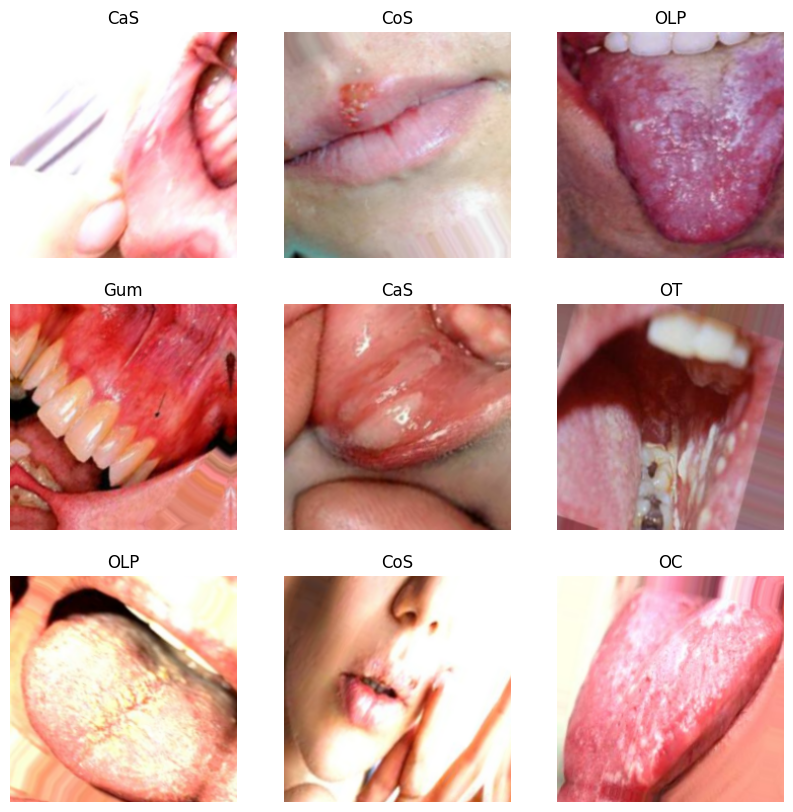

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        aug_img = data_augmentation(images)[i].numpy().astype("uint8")
        plt.subplot(3, 3, i + 1)
        plt.imshow(aug_img)
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")
plt.show()

In [7]:
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=img_size + (3,),
    weights=None
)
base_model.trainable = False  # freeze backbone

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)   # (batch, h, w, c)

# ---- Custom Head ----
x = layers.Conv2D(512, (3,3), activation="relu", padding="same")(x)
x = layers.Dropout(0.3)(x)

x = layers.AveragePooling2D(pool_size=(2,2))(x)   # OK
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
x = layers.Dropout(0.3)(x)

x = layers.MaxPooling2D(pool_size=(2,2))(x)       # OK
x = layers.Dropout(0.3)(x)


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

# Dense classifier
# x = layers.Dense(256, activation="relu")(x)
# x = layers.Dropout(0.3)(x)

outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 512)      │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 3, 3, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,130,026 (42.46 MB)

 Trainable params: 7,080,455 (27.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
#train the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500
)

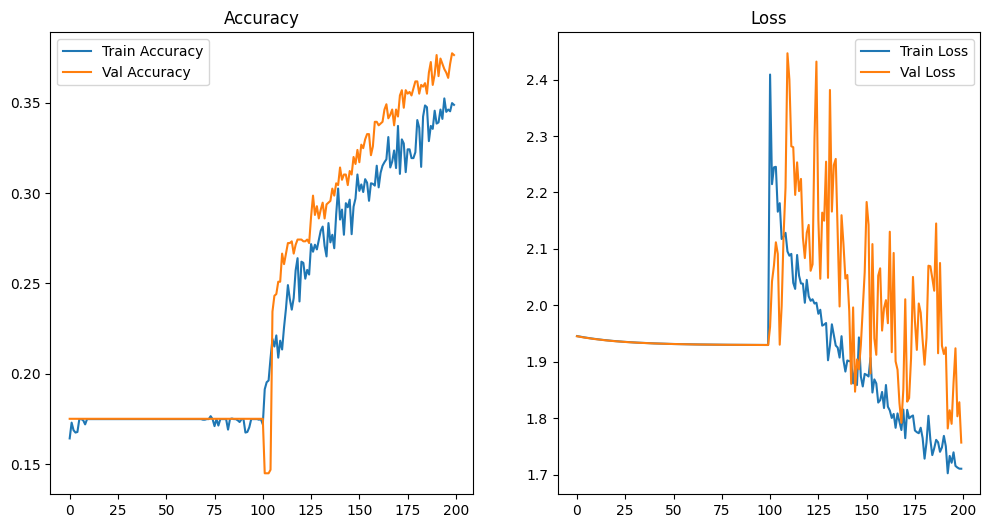

In [21]:
acc = history.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_finetune.history["val_accuracy"]
loss = history.history["loss"] + history_finetune.history["loss"]
val_loss = history.history["val_loss"] + history_finetune.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


In [ ]:
model.save("teeth_classification_model.h5")
print("Model saved as teeth_classification_model.h5")

Model saved as teeth_classification_model.h5
